<a href="https://colab.research.google.com/github/vitesempl/RK-IDE-Julia/blob/master/Julia%201.6.2%20on%20Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Steps how to run Julia
1.   Run the first block and install Julia Kernel
2.   Go to notebook settings
3.   Select `Julia` again as runtime



## Installing **Julia** on **Google Colab**

In [1]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.6.2" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia Plots"
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -n "$COLAB_GPU" ] && [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  if [ "$COLAB_GPU" = "1" ]; then
      JULIA_PACKAGES="$JULIA_PACKAGES"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia  

  echo ''
  echo "Success! Go to notebook settings and select again Julia as runtime."
fi

Installing Julia 1.6.2 on the current Colab Runtime...
2021-09-18 00:54:57 URL:https://storage.googleapis.com/julialang2/bin/linux/x64/1.6/julia-1.6.2-linux-x86_64.tar.gz [112946671/112946671] -> "/tmp/julia.tar.gz" [1]
Installing Julia package IJulia...
Installing Julia package Plots...
Installing IJulia kernel...
[ Info: Installing julia kernelspec in /root/.local/share/jupyter/kernels/julia-1.6

Success! Go to notebook settings and select again Julia as runtime.


#**Julia Code**#

In [1]:
versioninfo()

Julia Version 1.6.2
Commit 1b93d53fc4 (2021-07-14 15:36 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Xeon(R) CPU @ 2.30GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, haswell)
Environment:
  JULIA_NUM_THREADS = 2


## **Including libraries**

### Including Google Drive's library with Runge-Kutta Method

In [3]:
using Pkg
Pkg.add(url="https://github.com/vitesempl/RK-IDE-Julia")

     Cloning git-repo `https://github.com/vitesempl/RK-IDE-Julia`
    Updating git-repo `https://github.com/vitesempl/RK-IDE-Julia`
    Updating registry at `~/.julia/registries/General`
   Resolving package versions...
    Updating `~/.julia/environments/v1.6/Project.toml`
  [7b8691fb] + RK v0.1.0 `https://github.com/vitesempl/RK-IDE-Julia#master`
    Updating `~/.julia/environments/v1.6/Manifest.toml`
  [7b8691fb] + RK v0.1.0 `https://github.com/vitesempl/RK-IDE-Julia#master`
Precompiling project...
  ✓ RK
  1 dependency successfully precompiled in 3 seconds (120 already precompiled, 3 skipped during auto due to previous errors)


In [5]:
using RK;

In [7]:
using Plots;

### To solve integro-differential equations with discrete delays use the function "ide_delay_solve". If there are no such delays, use "ide_solve"

## Definition of functions for output 

In [8]:
# Output numerical solution in the end
function Output()
    nz = length(history(tspan[1]));
    if nz == 1
        println("y(",tspan[2],") = ",sol[2][end]);
    else
        for i = 1 : nz
            println("y",i,"(",tspan[2],") = ",(sol[2]')[end-nz+i]);
        end
    end
end

# Check 4-order of examples
# 1 - if equation has discrete delays z, 0 - if otherwise
function err_calc(hasDelays)
    n      = 8;
    err    = zeros(n);
    nsteps = zeros(n);

    for steppow = 1:n
        stepsize = (2.0)^(-steppow);
        
        if hasDelays == 1
            sol = ide_delay_solve(idefun,delays,K,delays_int,history,tspan,stepsize);
        else
            sol = ide_solve(idefun,K,delays_int,history,tspan,stepsize);
        end

        err[steppow] = abs(true_sol - sol[2][end]);
        nsteps[steppow] = stepsize;
    end

    println("Convergence order: ",(log10(err[end-1])-log10(err[end]))/(log10((2.0)^(-n+1))-log10((2.0)^(-n))));

    p2 = plot(err, nsteps, xaxis=:log10, yaxis=:log10, xlabel="ERROR", ylabel="STEPSIZE",legend=false, title = "Convergence order");

    plot(p1, p2, layout=(2,1), size = (600, 800))
end

err_calc (generic function with 1 method)

## Example 1 (only integral)

y(5.0) = 148.41315925335257
Convergence order: 4.001770395412852


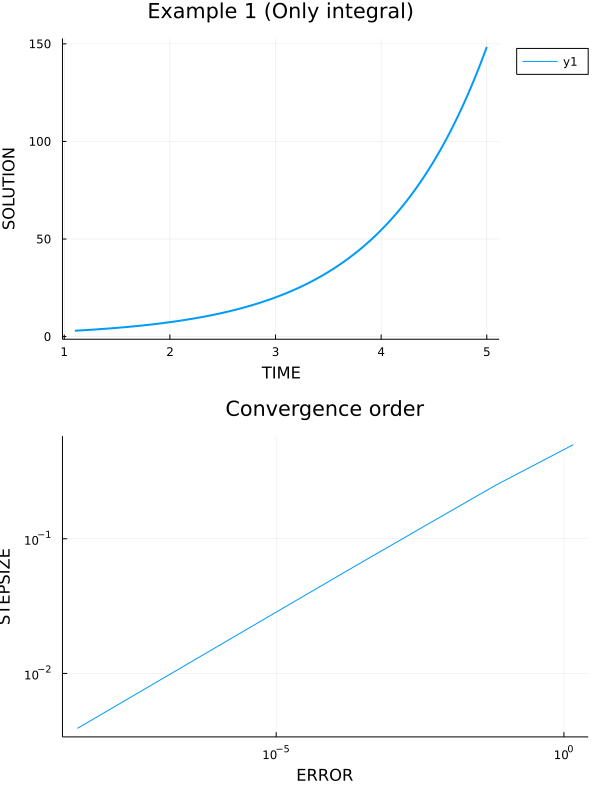

In [10]:
tspan = [1.1 5];
idefun(t,y,i) = ((t-1)*exp(t*t)*i)/(exp(-1)*y[1]-1);
K(t,s,y)      = y*exp(-s*t);
delays_int(t) = t-1; # delays of integrals
history(t)    = exp(t);

sol = ide_solve(idefun,K,delays_int,history,tspan,1e-2);

# Output vector of times t     #print(sol[1])
# Output vector of solutions y #print(sol[2])
Output();

p1 = plot(sol, linewidth=2, xlabel="TIME", ylabel="SOLUTION", title="Example 1 (Only integral)", legend=:outertopright);

# Check 4-order of Example 1
function fun(t)
    return exp(t);
end
true_sol = fun(tspan[end]);

# 1 - if equation has discrete delays z, 0 - if otherwise
err_calc(0) 

## Example 2 (integral+discrete delays)

y(10) = -0.8390715237122074
Convergence order: 3.994248239316921


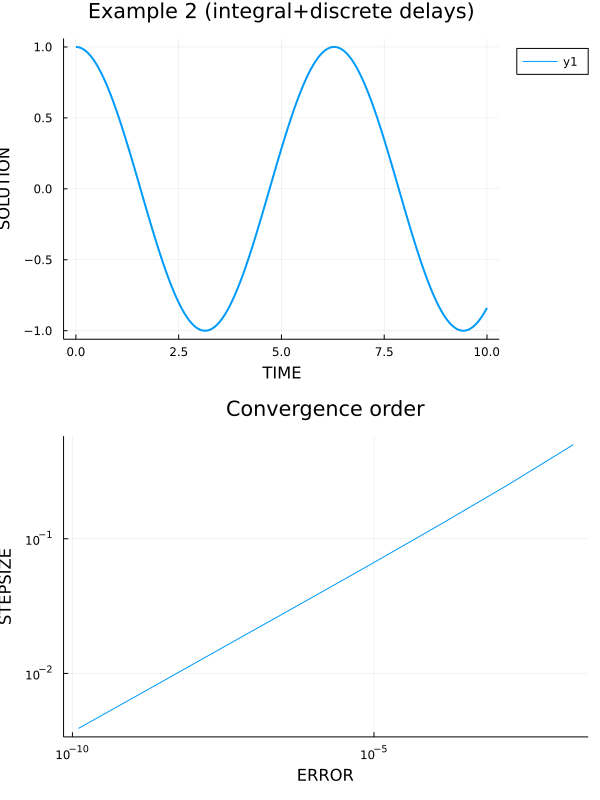

In [ ]:
tspan = [0 10];
idefun(t,y,z,i) = (1+exp(-pi/2))*y-exp(-pi/2)*z-2*exp(-2*t)*i;
K(t,s,y)        = y*exp(t+s); 
delays(t,y)     = t-pi/2;
delays_int(t)   = t-pi/2;
history(t)      = cos(t);

sol = ide_delay_solve(idefun,delays,K,delays_int,history,tspan,1e-2);

Output();

p1 = plot(sol, linewidth=2, xlabel="TIME", ylabel="SOLUTION", title="Example 2 (integral+discrete delays)", legend=:outertopright);

# Check 4-order of Example 2
function fun(t)
    return cos(t);
end
true_sol = fun(tspan[end]);

err_calc(1)

## Example 3 (integral+discrete delays+overlapping)

y(5) = 0.006737946981458059
Convergence order: 3.9949091111752955


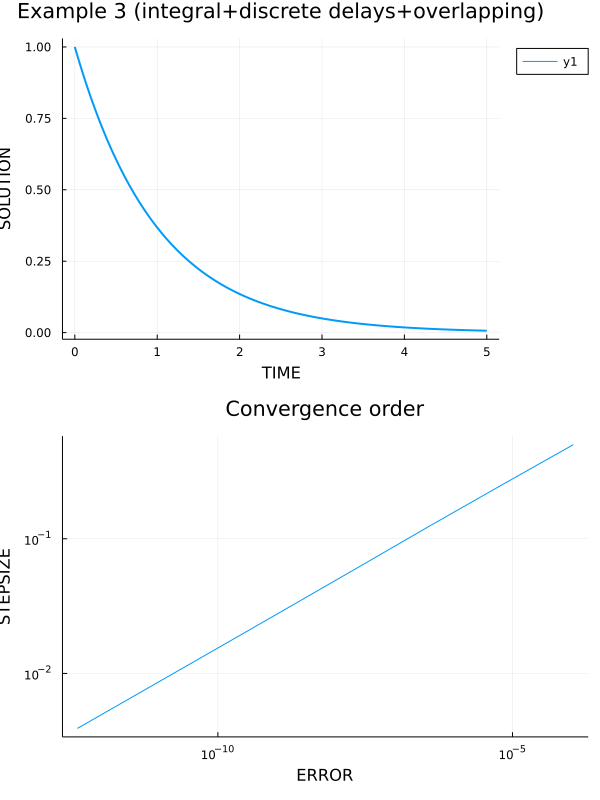

In [ ]:
tspan = [0 5];
idefun(t,y,z,i) = -y.^2-t*exp(t^2)*z^4*i;
K(t,s,y)        = y*exp(s-s*t); 
delays(t,y)     = t/2;
delays_int(t)   = t-1;
history(t)      = exp(-t);

sol = ide_delay_solve(idefun,delays,K,delays_int,history,tspan,1e-2);

Output();

p1 = plot(sol, linewidth=2, xlabel="TIME", ylabel="SOLUTION", title="Example 3 (integral+discrete delays+overlapping)", legend=:outertopright);

# Check 4-order of Example 3
function fun(t)
    return exp(-t);
end
true_sol = fun(tspan[end])

err_calc(1)

## Example 4 (2 integrals)

y(5) = 148.41315915325342
Convergence order: 3.992938268473011


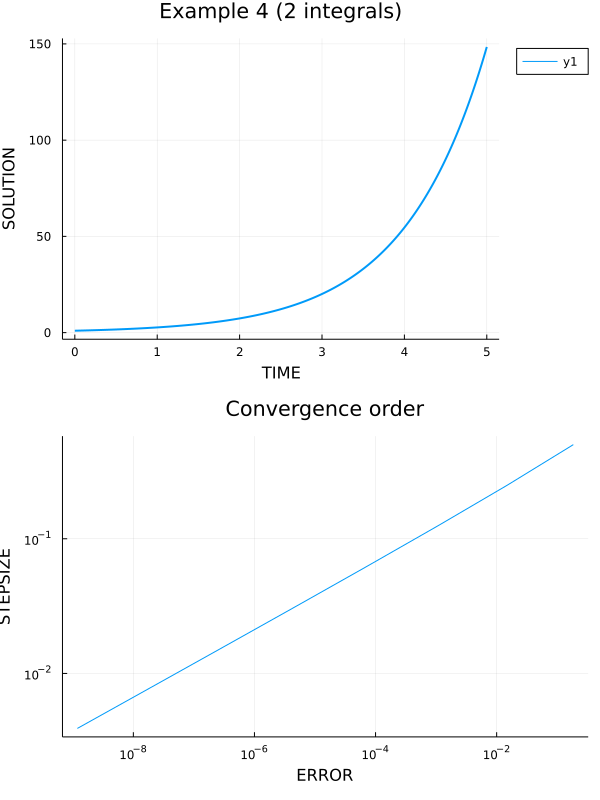

In [ ]:
tspan = [0 5];
idefun(t,y,z,i) = exp(1)-exp(t^2)/(z[1]^2)*(i[1]-exp(-2*t)*i[2])*(t-1);
K(t,s,y)        = [ y*exp(-s*t);
                    y*exp(t*(2-s))];
delays(t,y)     = t-1;
delays_int(t)   = [ t-1;
                    t-2 ];
history(t)      = exp(t);

sol = ide_delay_solve(idefun,delays,K,delays_int,history,tspan,1e-2);

Output();

p1 = plot(sol, linewidth=2, xlabel="TIME", ylabel="SOLUTION", title="Example 4 (2 integrals)", legend=:outertopright);

# Check 4-order of Example 4
function fun(t)
    return exp(t);
end
true_sol = fun(tspan[end])

err_calc(1)

## Example 5 (2 discrete delays + *State-dependent*)

y(5) = 0.006737947029428378
Convergence order: 4.034954918091005


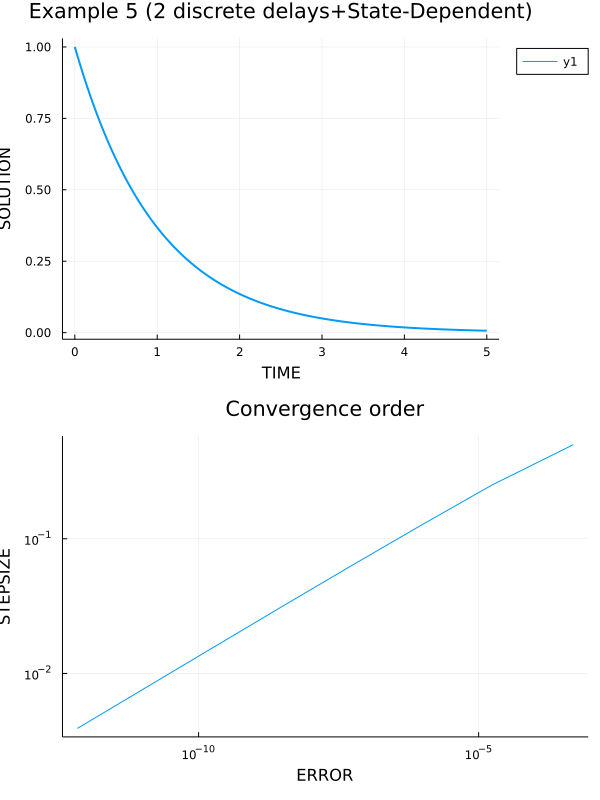

In [ ]:
tspan = [0 5];
idefun(t,y,z,i) = -z[1]^((t+1)/2) * z[2] * y.^2 * (1+exp(t^2)*t*i[1]) / exp(1/2);
K(t,s,y)        = y*exp(s-s*t);
delays(t,y)     = [ (log(y[1]))^2 / (t+1) - 1/2;
                    (t-1) / 4 ];
delays_int(t)   = t/2-1;
history(t)      = exp(-t);

sol = ide_delay_solve(idefun,delays,K,delays_int,history,tspan,1e-2);

Output();

p1 = plot(sol, linewidth=2, xlabel="TIME", ylabel="SOLUTION", title="Example 5 (2 discrete delays+State-Dependent)", legend=:outertopright);

# Check 4-order of Example 5
function fun(t)
    return exp(-t);
end
true_sol = fun(tspan[end])

err_calc(1)

## Example 6 (system of equations)



y1(10) = 0.004329876789507738
y2(10) = -9.145191243883074
y3(10) = 22.026465794883663


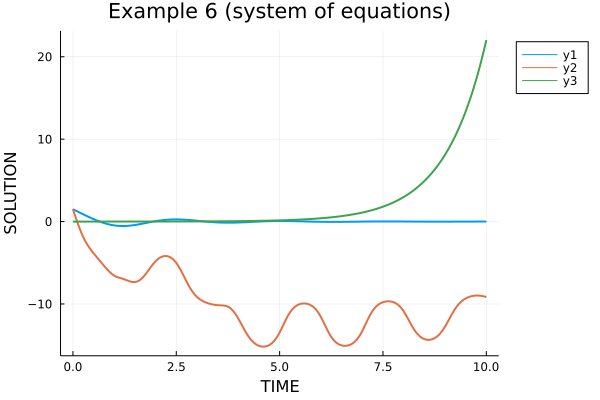

In [ ]:
tspan = [0 10];
idefun(t,y,i) = [ -2.5*i[1];
                   -15*i[2];
                  0.001*exp(t)];
K(t,s,y)      = [ sin(y[1]);
                  sin(y[2])];
delays_int(t) = [ t-1;
                  t-1 ];
history(t)    = [ 1.5;
                  1.5;
                  0.001*exp(t)];

sol = ide_solve(idefun,K,delays_int,history,tspan,1e-2);

Output();

plot(sol, linewidth=2, xlabel="TIME", ylabel="SOLUTION", title="Example 6 (system of equations)", legend=:outertopright)

## Examples (Yukihiko)

y(25) = -2.0422322798209653


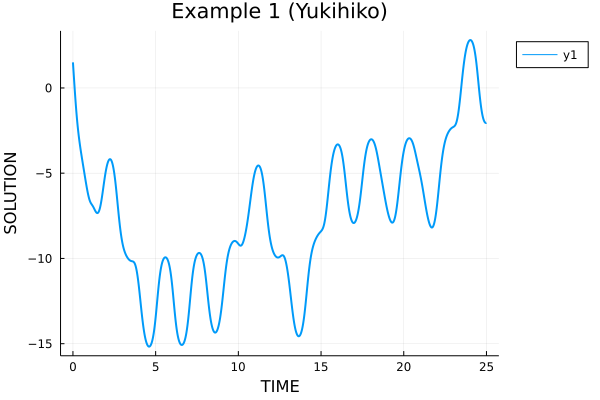

In [ ]:
tspan = [0 25];
idefun(t,y,i) = -15*i;
K(t,s,y)      = sin(y); 
delays_int(t) = t-1;
history(t)    = 1.5;

sol = ide_solve(idefun,K,delays_int,history,tspan,1e-2);

Output();

plot(sol, linewidth=2, xlabel="TIME", ylabel="SOLUTION", title="Example 1 (Yukihiko)", legend=:outertopright)

y(25) = -1.216745086566776


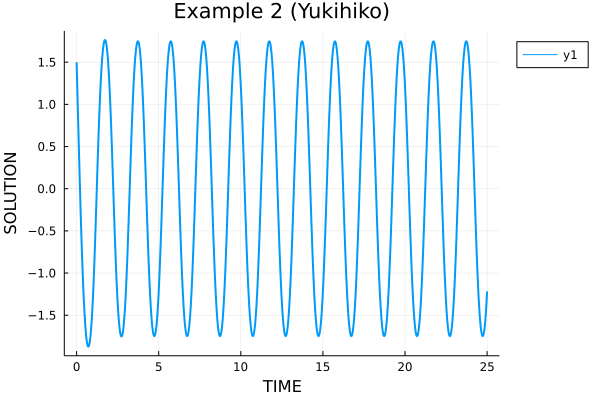

In [ ]:
idefun(t,y,i) = -7.5*i;
sol = ide_solve(idefun,K,delays_int,history,tspan,1e-2);
Output();
plot(sol, linewidth=2, xlabel="TIME", ylabel="SOLUTION", title="Example 2 (Yukihiko)", legend=:outertopright)

y(25) = 8.176591500707333e-7


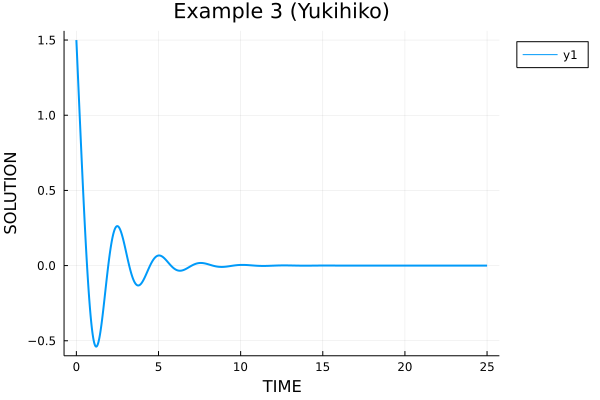

In [ ]:
idefun(t,y,i) = -2.5*i;
sol = ide_solve(idefun,K,delays_int,history,tspan,1e-2);
Output();
plot(sol, linewidth=2, xlabel="TIME", ylabel="SOLUTION", title="Example 3 (Yukihiko)", legend=:outertopright)

y1(25) = 8.176591500707333e-7
y2(25) = -1.216745086566776
y3(25) = -2.0422322798209653


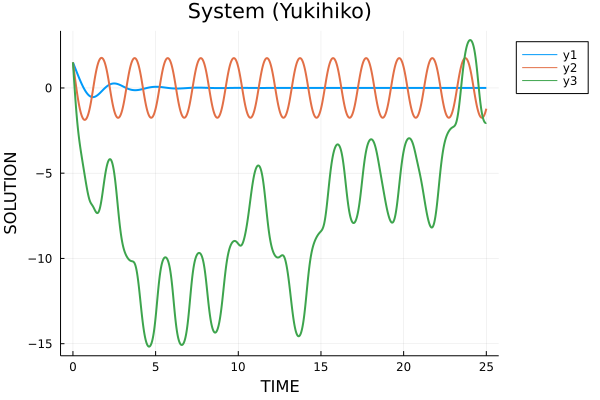

In [ ]:
tspan = [0 25];
idefun(t,y,i) = [ -2.5*i[1];
                  -7.5*i[2];
                   -15*i[3] ];
K(t,s,y)      = [ sin(y[1]);
                  sin(y[2]);
                  sin(y[3]) ];
delays_int(t) = [ t-1;
                  t-1;
                  t-1 ]; 
history(t)    = [ 1.5;
                  1.5;
                  1.5 ];

sol = ide_solve(idefun,K,delays_int,history,tspan,1e-2);

Output();
plot(sol, linewidth=2, xlabel="TIME", ylabel="SOLUTION", title="System (Yukihiko)", legend=:outertopright)

## Speed test (5 examples)



In [ ]:
stepsize = 1e-3;

In [ ]:
tspan = [1.1 5];
idefun(t,y,i) = ((t-1)*exp(t*t)*i)/(exp(-1)*y[1]-1);
K(t,s,y)      = y*exp(-s*t);
delays_int(t) = t-1; # delays of integrals
history(t)    = exp(t);

print("Elapsed time:")
@time sol = ide_solve(idefun,K,delays_int,history,tspan,stepsize);

Output();

Elapsed time: 24.698620 seconds (326.00 M allocations: 16.234 GiB, 11.30% gc time, 3.18% compilation time)
y(5.0) = 148.41315910257708


In [ ]:
tspan = [0 5];
idefun(t,y,z,i) = -y.^2-t*exp(t^2)*z^4*i;
K(t,s,y)        = y*exp(s-s*t); 
delays(t,y)     = t/2;
delays_int(t)   = t-1;
history(t)      = exp(-t);

print("Elapsed time:")
@time sol = ide_delay_solve(idefun,delays,K,delays_int,history,tspan,stepsize);

Output();

Elapsed time: 34.562385 seconds (451.34 M allocations: 22.090 GiB, 11.12% gc time, 2.63% compilation time)
y(5) = 0.006737946999098351


In [ ]:
tspan = [0 5];
idefun(t,y,z,i) = exp(1)-exp(t^2)/(z[1]^2)*(i[1]-exp(-2*t)*i[2])*(t-1);
K(t,s,y)        = [ y*exp(-s*t);
                    y*exp(t*(2-s))];
delays(t,y)     = t-1;
delays_int(t)   = [ t-1;
                    t-2 ];
history(t)      = exp(t);

print("Elapsed time:")
@time sol = ide_delay_solve(idefun,delays,K,delays_int,history,tspan,stepsize);

Output();

Elapsed time: 97.469171 seconds (1.37 G allocations: 66.112 GiB, 11.75% gc time, 1.37% compilation time)
y(5) = 148.413159102556


In [ ]:
tspan = [0 5];
idefun(t,y,z,i) = -z[1]^((t+1)/2) * z[2] * y.^2 * (1+exp(t^2)*t*i[1]) / exp(1/2);
K(t,s,y)        = y*exp(s-s*t);
delays(t,y)     = [ (log(y[1]))^2 / (t+1) - 1/2;
                    (t-1) / 4 ];
delays_int(t)   = t/2-1;
history(t)      = exp(-t);

print("Elapsed time:")
@time sol = ide_delay_solve(idefun,delays,K,delays_int,history,tspan,stepsize);

Output();

Elapsed time: 75.461104 seconds (1.03 G allocations: 49.133 GiB, 11.23% gc time, 1.45% compilation time)
y(5) = 0.006737946999088437


In [ ]:
tspan = [0 10];
idefun(t,y,i) = [ -2.5*i[1];
                     -15*i[2];
                    0.001*exp(t)];
K(t,s,y)      = [ sin(y[1]);
                  sin(y[2])];
delays_int(t) = [ t-1;
                  t-1 ];
history(t)    = [ 1.5;
                  1.5;
                  0.001*exp(t)];

print("Elapsed time:")
@time sol = ide_solve(idefun,K,delays_int,history,tspan,stepsize);

Output();

Elapsed time:202.544869 seconds (2.04 G allocations: 121.535 GiB, 14.01% gc time, 0.55% compilation time)
y1(10) = 0.004329876785625872
y2(10) = -9.145131176514756
y3(10) = 22.026465794816332
